In [1]:
#pip install seaborn

  Using cached https://files.pythonhosted.org/packages/10/5b/0479d7d845b5ba410ca702ffcd7f2cd95a14a4dfff1fde2637802b258b9b/seaborn-0.11.2-py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/c3/e2/00cacecafbab071c787019f00ad84ca3185952f6bb9bca9550ed83870d4d/pandas-1.1.5-cp36-cp36m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/09/03/b7b30fa81cb687d1178e085d0f01111ceaea3bf81f9330c937fb6f6c8ca0/matplotlib-3.3.4-cp36-cp36m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/c8/89/63171228d5ced148f5ced50305c89e8576ffc695a90b58fe5bb602b910c2/scipy-1.5.4-cp36-cp36m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/45/b2/6c7545bb7a38754d63048c7696804a0d947328125d81bf12beaa692c3ae3/numpy-1.19.5-cp36-cp36m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/36/7a/87837f39d0296e723bb9b62bbb257d0355c7f6128853c78955f57342a56d/python_dateutil-2.8.2-py2.py3-none-any.whl
  Usin

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
# to visualise al the columns in the dataframe
pd.pandas.set_option('display.max_columns', None)


import seaborn as sns

from scipy import stats
from scipy.stats import norm, skew 

In [5]:
#Spark libraries
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession, SQLContext

from pyspark.sql.types import *
import pyspark.sql.functions as F
from pyspark.sql.functions import udf, col

from pyspark.ml.regression import LinearRegression
from pyspark.mllib.evaluation import RegressionMetrics

from pyspark.ml.tuning import ParamGridBuilder, CrossValidator, CrossValidatorModel
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.evaluation import RegressionEvaluator

In [6]:
spark_session = SparkSession.builder.master("local[2]").appName("HousingRegression").getOrCreate()


In [7]:
spark_context = spark_session.sparkContext

In [8]:
spark_sql_context = SQLContext(spark_context)

In [11]:
#Data Loading

train = pd.read_csv('Downloads/house-prices-advanced-regression-techniques/train.csv')
test = pd.read_csv('Downloads/house-prices-advanced-regression-techniques/test.csv')

In [12]:
train.shape,test.shape

((1460, 81), (1459, 80))

In [17]:
#check the percentage of nan values present in each feature
## 1 -step make the list of features which has missing values
features_with_na=[features for features in train.columns if train[features].isnull().sum()>1]
## 2- step print the feature name and the percentage of missing values

for feature in features_with_na:
    print(feature, np.round(train[feature].isnull().mean(), 4),  ' % missing values')

LotFrontage 0.1774  % missing values
Alley 0.9377  % missing values
MasVnrType 0.0055  % missing values
MasVnrArea 0.0055  % missing values
BsmtQual 0.0253  % missing values
BsmtCond 0.0253  % missing values
BsmtExposure 0.026  % missing values
BsmtFinType1 0.0253  % missing values
BsmtFinType2 0.026  % missing values
FireplaceQu 0.4726  % missing values
GarageType 0.0555  % missing values
GarageYrBlt 0.0555  % missing values
GarageFinish 0.0555  % missing values
GarageQual 0.0555  % missing values
GarageCond 0.0555  % missing values
PoolQC 0.9952  % missing values
Fence 0.8075  % missing values
MiscFeature 0.963  % missing values


/home/pv/.local/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'SalePrice distribution')

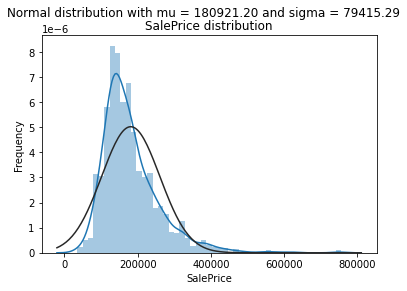

In [19]:
sns.distplot(train['SalePrice'] , fit=norm);

# parameters
(mu, sigma) = norm.fit(train['SalePrice'])

plt.suptitle('Normal distribution with mu = {:.2f} and sigma = {:.2f}'.format(mu, sigma))
plt.ylabel('Frequency')
plt.title('SalePrice distribution')


In [21]:
# Correaltion Matrix
corr = train.corr()

In [22]:
corr[['SalePrice']].sort_values(by='SalePrice',ascending=False).style.background_gradient(cmap='viridis', axis=None)

,SalePrice
SalePrice,1.000000
OverallQual,0.790982
GrLivArea,0.708624
GarageCars,0.640409
GarageArea,0.623431
TotalBsmtSF,0.613581
1stFlrSF,0.605852
FullBath,0.560664
TotRmsAbvGrd,0.533723
YearBuilt,0.522897


Text(0.5, 1.0, 'GarageCars vs SalePrice')

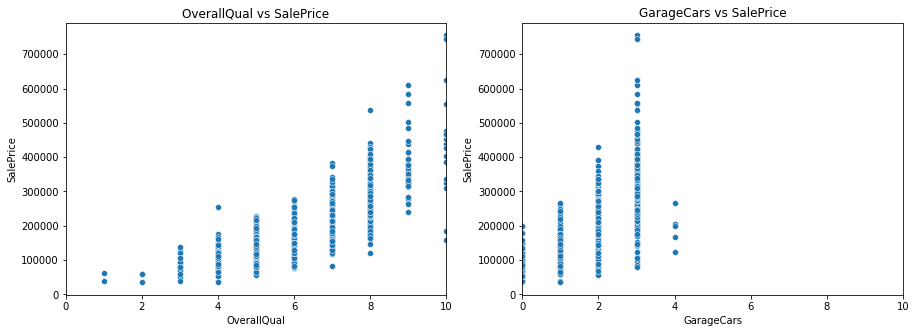

In [24]:
#Explore for outliers
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(15,5))
axes[0].set_xlim(0,10)

sns.scatterplot(data=train, ax=axes[0], x='OverallQual', y='SalePrice')
axes[0].set_title('OverallQual vs SalePrice')
sns.scatterplot(data=train, ax=axes[1], x='GarageCars', y='SalePrice')
axes[1].set_title('GarageCars vs SalePrice')


Text(0.5, 1.0, 'GarageArea vs SalePrice')

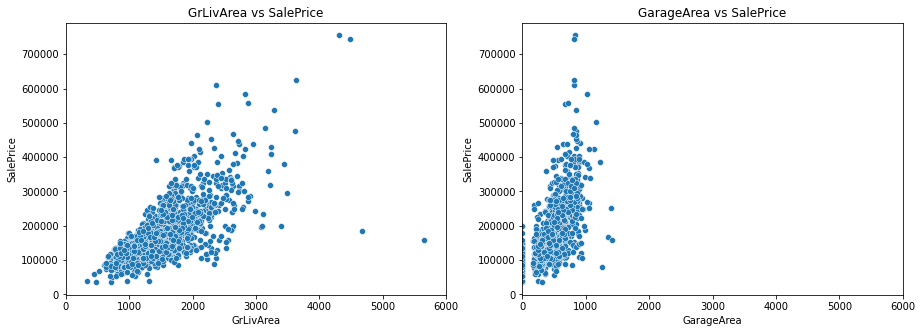

In [25]:
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(15,5))
axes[0].set_xlim(0, 6000)

sns.scatterplot(data=train, ax=axes[0], x='GrLivArea', y='SalePrice')
axes[0].set_title('GrLivArea vs SalePrice')
sns.scatterplot(data=train, ax=axes[1], x='GarageArea', y='SalePrice')
axes[1].set_title('GarageArea vs SalePrice')

In [27]:
# Missing data handling
total = train.isnull().sum().sort_values(ascending=False)
percent = (train.isnull().sum()/train.shape[0]).sort_values(ascending=False)

missing = pd.concat([total, percent], axis=1, keys=['Total', 'Perc_missing'])
missing.head(20)

,Total,Perc_missing
PoolQC,1453,0.995205
MiscFeature,1406,0.963014
Alley,1369,0.937671
Fence,1179,0.807534
FireplaceQu,690,0.472603
LotFrontage,259,0.177397
GarageCond,81,0.055479
GarageType,81,0.055479
GarageYrBlt,81,0.055479
GarageFinish,81,0.055479


In [28]:
# remove features with missing proportion of more than 15% (thumb rule)

train = train.drop((missing[missing['Perc_missing'] >= 0.15]).index,1)
train.head()

,Id,MSSubClass,MSZoning,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,0,2,2008,WD,Normal,208500
1,2,20,RL,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,0,5,2007,WD,Normal,181500
2,3,60,RL,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,0,9,2008,WD,Normal,223500
3,4,70,RL,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,0,2,2006,WD,Abnorml,140000
4,5,60,RL,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,0,12,2008,WD,Normal,250000


In [29]:
train['New'] = train['OverallQual'] * train['GarageArea'] * train['GrLivArea']
test['New'] = test['OverallQual'] * test['GarageArea'] * test['GrLivArea']

In [30]:
train_cols = list(train.columns)
train_cols.remove('SalePrice')


In [31]:
#Make test ds feature set same as in train ds
test = test[train_cols]

In [32]:
test.columns[test.isna().any()].tolist()

['MSZoning',
 'Utilities',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'MasVnrArea',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinSF1',
 'BsmtFinType2',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 'BsmtFullBath',
 'BsmtHalfBath',
 'KitchenQual',
 'Functional',
 'GarageType',
 'GarageYrBlt',
 'GarageFinish',
 'GarageCars',
 'GarageArea',
 'GarageQual',
 'GarageCond',
 'SaleType',
 'New']

In [33]:
# Althoug this is not the best solution to fill the NA-values with "None"/0, for most of the features 
# in the particular datas, it literally means "None"/0 (e.g. Garage Area, Garage Type, Condition) as the house
# probably doesn't have the garage.

for col in ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']:
    train[col] = train[col].fillna("None")
    test[col] = test[col].fillna("None")
    
for col in ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']:
    train[col] = train[col].fillna("None")
    test[col] = test[col].fillna("None")
    
for col in ['GarageYrBlt', 'GarageArea', 'GarageCars']:
    train[col] = train[col].fillna(0)
    test[col] = test[col].fillna(0)
    
train['MasVnrType'] = train['MasVnrType'].fillna("None")
test['MasVnrType'] = test['MasVnrType'].fillna("None")

train['MasVnrArea'] = train['MasVnrArea'].fillna(0)
test['MasVnrArea'] = test['MasVnrArea'].fillna(0)

train['Electrical'] = train['Electrical'].fillna(train['Electrical'].mode()[0])
test['Electrical'] = test['Electrical'].fillna(test['Electrical'].mode()[0])

print(train.isnull().sum().max()) # check if any missing values are left
print(test.isnull().sum().max())

0
4


In [34]:
test['BsmtFinSF1'] = test['BsmtFinSF1'].fillna(test['BsmtFinSF1'].mean())
test['BsmtFinSF2'] = test['BsmtFinSF2'].fillna(test['BsmtFinSF2'].mean())
test['BsmtUnfSF'] = test['BsmtUnfSF'].fillna(test['BsmtUnfSF'].mean())
test['TotalBsmtSF'] = test['TotalBsmtSF'].fillna(test['TotalBsmtSF'].mean())
test['BsmtFullBath'] = test['BsmtFullBath'].fillna(test['BsmtFullBath'].mean())
test['BsmtHalfBath'] = test['BsmtHalfBath'].fillna(test['BsmtHalfBath'].mean())

In [ ]:
# This is how fillna is done in PySpark

# train_df = train_df.na.fill('NoData', subset=['MSZoning', 'Utilities', 'Exterior1st', 'Exterior2nd', 'BsmtFinSF1',
#       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath',
#       'BsmtHalfBath', 'KitchenQual', 'Functional', 'GarageCars', 'GarageArea','SaleType'])
# test_df = test_df.na.fill('NoData', subset=['MSZoning', 'Utilities', 'Exterior1st', 'Exterior2nd', 'BsmtFinSF1',
#       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath',
#       'BsmtHalfBath', 'KitchenQual', 'Functional', 'GarageCars', 'GarageArea','SaleType'])

In [35]:
cat_columns = train.select_dtypes(include=['object']).columns
train[cat_columns] = train[cat_columns].fillna('NoData')
test[cat_columns] = test[cat_columns].fillna('NoData')


In [36]:
#HAndling outliers

print("Dropping outliers resulted in %d instances in the new dataset" % len(train))
train = train.drop(train[(train['GrLivArea']>4500) 
                                & (train['SalePrice']<300000)].index)
print("Dropping outliers resulted in %d instances in the new dataset" % len(train))
train = train.drop(train[(train['GrLivArea']>5500) 
                                | (train['SalePrice']>500000)].index)
print("Dropping outliers resulted in %d instances in the new dataset" % len(train))
train = train.drop(train[train['GarageArea']>1100].index)
print("Dropping outliers resulted in %d instances in the new dataset" % len(train))

Dropping outliers resulted in 1460 instances in the new dataset
Dropping outliers resulted in 1458 instances in the new dataset
Dropping outliers resulted in 1449 instances in the new dataset
Dropping outliers resulted in 1444 instances in the new dataset


In [38]:
#Creating Spark Dataframes
train_df = spark_session.createDataFrame(train)
test_df = spark_session.createDataFrame(test)


In [39]:
train_df = train_df.select([c for c in train_df.columns if c not in na_cols])
train_cols = train_df.columns
train_cols.remove('SalePrice')
test_df = test_df.select(train_cols)


In [40]:
from pyspark.sql.types import IntegerType

# As PySpark DFs can be finicky, sometimes your have to explicitly cast certain data types to columns

test_df = test_df.withColumn("BsmtFinSF1", test_df["BsmtFinSF1"].cast(IntegerType()))
test_df = test_df.withColumn("BsmtFinSF2", test_df["BsmtFinSF2"].cast(IntegerType()))
test_df = test_df.withColumn("BsmtUnfSF", test_df["BsmtUnfSF"].cast(IntegerType()))
test_df = test_df.withColumn("TotalBsmtSF", test_df["TotalBsmtSF"].cast(IntegerType()))
test_df = test_df.withColumn("BsmtFullBath", test_df["BsmtFullBath"].cast(IntegerType()))
test_df = test_df.withColumn("BsmtHalfBath", test_df["BsmtHalfBath"].cast(IntegerType()))
test_df = test_df.withColumn("GarageCars", test_df["GarageCars"].cast(IntegerType()))
test_df = test_df.withColumn("GarageArea", test_df["GarageArea"].cast(IntegerType()))

# train_df.printSchema()

In [41]:
# Defining string columns to pass on to the String Indexer (= categorical feature encoding)

train_string_columns = []

for col, dtype in train_df.dtypes:
    if dtype == 'string':
        train_string_columns.append(col)

In [42]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer

indexers = [StringIndexer(inputCol=column, outputCol=column+'_index', handleInvalid='keep').fit(train_df) for column in train_string_columns]


pipeline = Pipeline(stages=indexers)
train_indexed = pipeline.fit(train_df).transform(train_df)

In [43]:
print(len(train_indexed.columns))

90


In [44]:
test_string_columns = []

for col, dtype in test_df.dtypes:
    if dtype == 'string':
        test_string_columns.append(col)


In [45]:
indexers2 = [StringIndexer(inputCol=column, outputCol=column+'_index', handleInvalid='keep').fit(test_df) for column in test_string_columns]

pipeline2 = Pipeline(stages=indexers2)
test_indexed = pipeline2.fit(test_df).transform(test_df)

In [46]:
def get_dtype(df,colname):
    return [dtype for name, dtype in df.dtypes if name == colname][0]

num_cols_train = []
for col in train_indexed.columns:
    if get_dtype(train_indexed,col) != 'string':
        num_cols_train.append(str(col))
        
num_cols_test = []
for col in test_indexed.columns:
    if get_dtype(test_indexed,col) != 'string':
        num_cols_test.append(str(col))

train_indexed = train_indexed.select(num_cols_train)
test_indexed = test_indexed.select(num_cols_test)

In [47]:
print(len(train_indexed.columns))
print(len(test_indexed.columns))


63
62


In [48]:
#Model Building
#Before passing the data on to the PySpark model, we need to vectorize the data.
from pyspark.ml.feature import VectorAssembler
vectorAssembler = VectorAssembler(inputCols = train_indexed.drop("SalePrice").columns, outputCol = 'features').setHandleInvalid("keep")

train_vector = vectorAssembler.transform(train_indexed)

In [49]:
vectorAssembler2 = VectorAssembler(inputCols = test_indexed.columns, outputCol = 'features').setHandleInvalid("keep")

test_vector = vectorAssembler2.transform(test_indexed)

In [50]:
from pyspark.sql.functions import lit

test_vector = test_vector.withColumn("SalePrice", lit(0))

In [51]:
#You can use this to scale all instances, however, as I checked, this did not improve the performance

#from pyspark.ml.feature import StandardScaler
#scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withStd=True, withMean=False)
#scalerModel = scaler.fit(train_vector)
#scaled_train = scalerModel.transform(train_vector)

#scalerModel2 = scaler.fit(test_vector)
#scaled_test = scalerModel2.transform(test_vector)

In [52]:
# Train-test split

splits = train_vector.randomSplit([0.7, 0.3])
train = splits[0]
val = splits[1]

In [53]:
# Simple linear regression

from pyspark.ml.regression import LinearRegression

lr = LinearRegression(featuresCol = 'features', labelCol='SalePrice', maxIter=10, 
                      regParam=0.8, elasticNetParam=0.1) # It is always a good idea to play with hyperparameters.
lr_model = lr.fit(train)

trainingSummary = lr_model.summary
print("RMSE: %f" % trainingSummary.rootMeanSquaredError)
print("r2: %f" % trainingSummary.r2)

lr_predictions = lr_model.transform(val)
lr_predictions.select("prediction","SalePrice","features").show(5)

from pyspark.ml.evaluation import RegressionEvaluator
lr_evaluator = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="SalePrice",metricName="r2")
print("R Squared (R2) on val data = %g" % lr_evaluator.evaluate(lr_predictions))

RMSE: 21419.945245
r2: 0.909344
+------------------+---------+--------------------+
|        prediction|SalePrice|            features|
+------------------+---------+--------------------+
| 184012.7948818368|   140000|(62,[0,1,2,3,4,5,...|
| 167125.3295554222|   143000|(62,[0,1,2,3,4,5,...|
|225965.63349716994|   200000|(62,[0,1,2,3,4,5,...|
| 135555.8817733841|   129500|(62,[0,1,2,3,4,5,...|
|349488.76305644074|   345000|(62,[0,1,2,3,4,5,...|
+------------------+---------+--------------------+
only showing top 5 rows

R Squared (R2) on val data = 0.893649


In [55]:
# A more complex model with RF

from pyspark.ml.regression import RandomForestRegressor

rf = RandomForestRegressor(featuresCol = 'features', labelCol='SalePrice', 
                           maxDepth=20, 
                           minInstancesPerNode=2,
                          # bootstrap=True
                          )
rf_model = rf.fit(train)

rf_predictions = rf_model.transform(val)
rf_predictions.select("prediction","SalePrice","features").show(5)

from pyspark.ml.evaluation import RegressionEvaluator
rf_evaluator = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="SalePrice",metricName="r2")
print("R Squared (R2) on val data = %g" % rf_evaluator.evaluate(rf_predictions))

+------------------+---------+--------------------+
|        prediction|SalePrice|            features|
+------------------+---------+--------------------+
|          210391.3|   140000|(62,[0,1,2,3,4,5,...|
| 146859.1666666667|   143000|(62,[0,1,2,3,4,5,...|
|          212031.5|   200000|(62,[0,1,2,3,4,5,...|
|133833.33333333334|   129500|(62,[0,1,2,3,4,5,...|
|        367254.725|   345000|(62,[0,1,2,3,4,5,...|
+------------------+---------+--------------------+
only showing top 5 rows

R Squared (R2) on val data = 0.874487


In [56]:
#Predictions and output data
rf_predictions2 = rf_model.transform(test_vector)
#rf_predictions2.printSchema()
pred = rf_predictions2.select("Id","prediction")
pred = pred.withColumnRenamed("prediction","SalePrice")

from pyspark.sql.types import FloatType, IntegerType

#pred.printSchema()
pred = pred.withColumn("Id", pred["Id"].cast(IntegerType()))
pred = pred.withColumn("SalePrice", pred["SalePrice"].cast(FloatType()))


In [57]:
pred_pd = pred.toPandas()
save = pred_pd.to_csv("submission.csv", index=False)
save

In [58]:
pred_pd

,Id,SalePrice
0,1461,129967.492188
1,1462,147854.578125
2,1463,171580.171875
3,1464,194424.078125
4,1465,213443.218750
...,...,...
1454,2915,110044.398438
1455,2916,113095.164062
1456,2917,165958.328125
1457,2918,117634.789062
